In [1]:
import tensorflow as tf

import os
from os.path import join
import numpy as np
import scipy.sparse

import sys
sys.path.append('../')

from networks.i2m import network_i2m_cam_densenet as i2m_net
from networks.spectral import spectral_ae

from training.i2m import data_loader as i2m_dl
from training.i2m.log import *
from training.i2m.loss import loss_function
from training.spectral import data_loader as spectral_dl
from training.model_config import AttrDict

from utils.utils import export_obj

import matplotlib.pyplot as plt
import cv2

# Suppress Tensorflow 2.0.0 deprecation warnings.
tf.logging.set_verbosity(tf.logging.ERROR)

W0801 16:06:23.235617 139658789889856 deprecation_wrapper.py:119] From ../training/i2m/data_loader.py:6: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



In [2]:
def visualize_keypoints(image, gt_kpts, pred_kpts, align_mesh, trilist, figsize=(12, 12)):
    fig = plt.figure(figsize=figsize)
    
    ax1 = fig.add_subplot('121')
    ax1.imshow(np.array(image, dtype=np.uint8))
    ax1.plot(gt_kpts[:, 0], gt_kpts[:, 1], 'ro')
    ax1.set_title('Ground Truth')
    ax1.axis('off')
    
    ax2 = fig.add_subplot('122')
    ax2.imshow(np.array(image, dtype=np.uint8))
    ax2.triplot(align_mesh[:,0].squeeze(), align_mesh[:,1].squeeze(), trilist, lw=0.5)
    ax2.plot(pred_kpts[:, 0], pred_kpts[:, 1], 'ro')
    ax2.set_title('Prediction')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
# Define the training parameters.
def define_config():
    config = AttrDict()

    config.n_epochs = 1
    config.batch_size = 32
    config.lr = 0.0001
    config.l2_reg = 0.00001
    config.z_l2_penalty = 0.00005
    config.cam_latent_variable = 32
    config.optimizer = 'AdamW'
    
    config.info = ""
    
    # Generator specification (fixed).
    config.mesh_latent_variable = 64
    config.filters = [16, 32, 32, 48]
    config.sampling_steps = len(config.filters)
    config.poly_order = [3] * config.sampling_steps
    config.type = 'sampling_{}'.format(config.sampling_steps)
    
    config.num_parallel_calls = 8

    return config

config = define_config()
num_parallel_calls = config.num_parallel_calls
mesh_latent_variable, cam_latent_variable, n_epochs = config.mesh_latent_variable, config.cam_latent_variable, config.n_epochs
batch_size, lr, l2_reg, z_l2_penalty = config.batch_size, config.lr, config.l2_reg, config.z_l2_penalty

## Load the image-to-mesh data

In [4]:
model_id = '1555053417.5808766.base'
spectral_model_id = 'z64_d4_1550943246.5350132'

# Define file paths.
ROOT = '..'
DATA_DIR = 'data'
DATA_PATH = join(ROOT, DATA_DIR)
DATASET_PATH = join(ROOT, DATA_DIR, 'datasets/hand-panoptic')
# Spectral operators.
TENPLATE_DATA_PATH = join(ROOT, DATA_DIR, 'template')
GRAPH_STRUCTURE = join(TENPLATE_DATA_PATH, config.type)
TRILIST_PATH = join(TENPLATE_DATA_PATH, 'trilist.npy')
# Saved decoder.
GENERATOR_OUTPUT_PATH = join(ROOT, DATA_DIR, 'models/spectral-ae', spectral_model_id)
GENERATOR_CHECKPOINT_PATH = join(GENERATOR_OUTPUT_PATH, 'models')
# Training logs.
OUTPUT_PATH = join(ROOT, DATA_DIR, 'models/i2m', model_id)
CHECKPOINT_PATH = join(OUTPUT_PATH, 'models')

# Load spectral operators.
L, A, D, U, p = spectral_dl.load_spectral_operators(GRAPH_STRUCTURE)
# Load the joint regressor.
J_regressor = np.array(np.load(join(TENPLATE_DATA_PATH, 'J_regressor.npy')), dtype=np.float32)

mean_points = np.load(join(TENPLATE_DATA_PATH, 'mean_points.npy'))
std = np.load(join(TENPLATE_DATA_PATH, 'std_points.npy'))

# Get the trilist for exporting the meshes.
trilist = np.load(TRILIST_PATH)

## Build data iterators

In [5]:
# Create dataset iterators.
TEST_SAMPLES = 1500 * 2

test_filenames = [join(DATASET_PATH, 'hand_domedb_test_lm.tfrecord'),
                  join(DATASET_PATH, 'hand_domedb_test_r.tfrecord')]

test_db = i2m_dl.create_dataset(test_filenames, n_epochs=n_epochs, batch_size=batch_size, 
                                shuffle=False, reshuffle=False,
								mean_points=mean_points, std=std, num_parallel_calls=num_parallel_calls)

handle, iterator = i2m_dl.create_feedable_iterator(test_db)
next_X, next_Y_mesh, next_Y_lms, next_Y_3d_kpts = iterator.get_next()

test_db_it = test_db.make_initializable_iterator()

In [6]:
test_db_viz = i2m_dl.create_dataset(test_filenames, n_epochs=n_epochs, batch_size=batch_size, 
                                shuffle=False, reshuffle=False, return_init_img=True,
								mean_points=mean_points, std=std, num_parallel_calls=num_parallel_calls)

test_viz_db_it = test_db_viz.make_initializable_iterator()

## Build the image-to-mesh network

In [7]:
J_regressor_tensor = tf.tile(tf.constant(np.expand_dims(J_regressor, 0)), [batch_size, 1, 1])
is_train = tf.placeholder(tf.bool, name="is_train")

mean_points_tensor = tf.expand_dims(mean_points, axis=0)
std_tensor = tf.expand_dims(std, axis=0)

output_mesh, mesh_embedding, camera_embedding, scale, trans, rot, restore_saver = i2m_net.build_network(
                                                                next_X, L, A, U,
                                                                is_train, mesh_latent_variable, cam_latent_variable)

loss, output_keypoints, output_3d_keypoints = loss_function(output_mesh, next_Y_mesh, 
                     next_Y_lms, next_Y_3d_kpts, 
                     scale, trans, rot,
                     mean_points_tensor, std_tensor, J_regressor_tensor,
                     l2_reg, mesh_embedding, z_l2_penalty, summary=True, return_kpts=True)

train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='image_encoder')
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

global_step = tf.Variable(0, name='global_step', trainable=False)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    init_opt = tf.contrib.opt.AdamWOptimizer(learning_rate=lr, weight_decay=0.00001)
    opt = init_opt.minimize(loss, global_step=global_step, var_list=train_vars)

## Evaluate the network

In [8]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    test_handle = sess.run(test_db_it.string_handle())
    test_viz_handle = sess.run(test_viz_db_it.string_handle())

    sess.run(init, feed_dict={handle: test_handle})

    sess.run(test_db_it.initializer)
    sess.run(test_viz_db_it.initializer)

    reuse_vars_dict = dict([(var.op.name, var) for var in all_vars if 'AdamW' not in var.op.name])
    saver = tf.train.Saver(reuse_vars_dict, max_to_keep=5, keep_checkpoint_every_n_hours=2)

    saver.restore(sess, join(CHECKPOINT_PATH, 'i2m.1555094177.3652265-130'))
    
    for _ in range(5): # Skip some samples.
        pred_mesh, gt_X, gt_mesh, gt_lms, scale_out, trans_out, rot_out, gt_3d_kpts, out_lms, out_3d_kpts = sess.run(
            [output_mesh, next_X, next_Y_mesh, next_Y_lms, scale, trans, rot, next_Y_3d_kpts,
             output_keypoints, output_3d_keypoints], 
            feed_dict={handle: test_handle, is_train: False})

        gt_X_viz = sess.run(next_X, feed_dict={handle: test_viz_handle, is_train: False})

    reconstruction = pred_mesh * std + mean_points
    rec_label = gt_mesh * std + mean_points

## Visualize the output

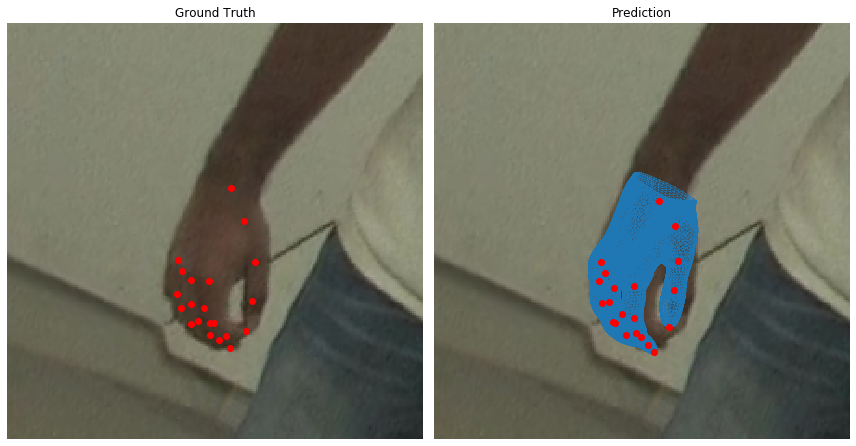

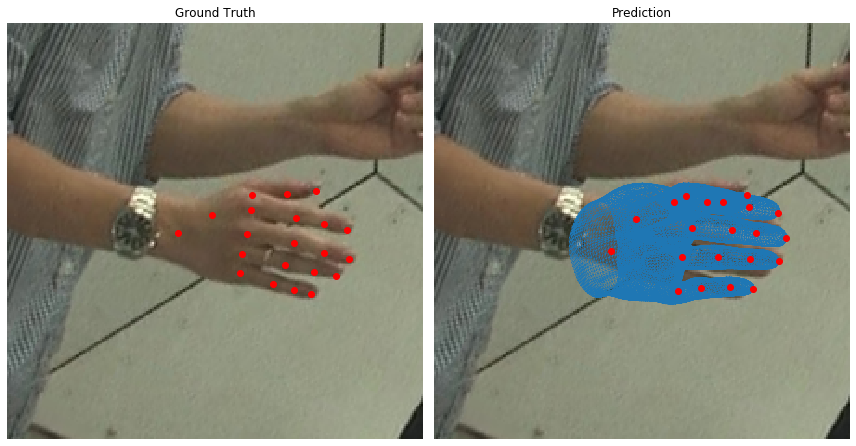

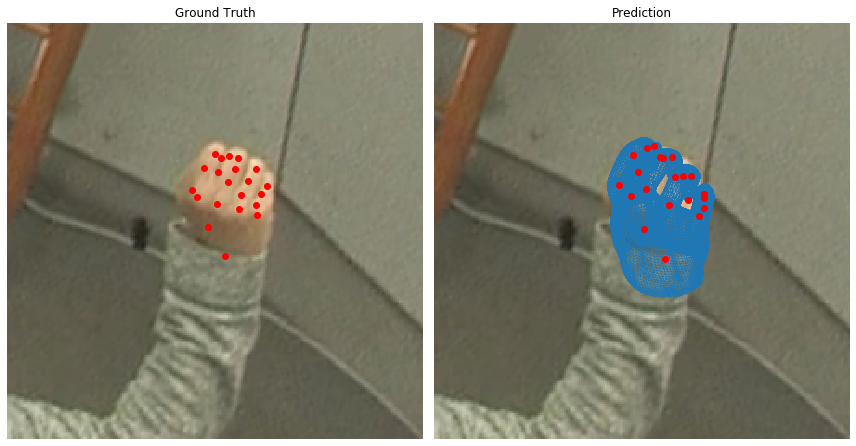

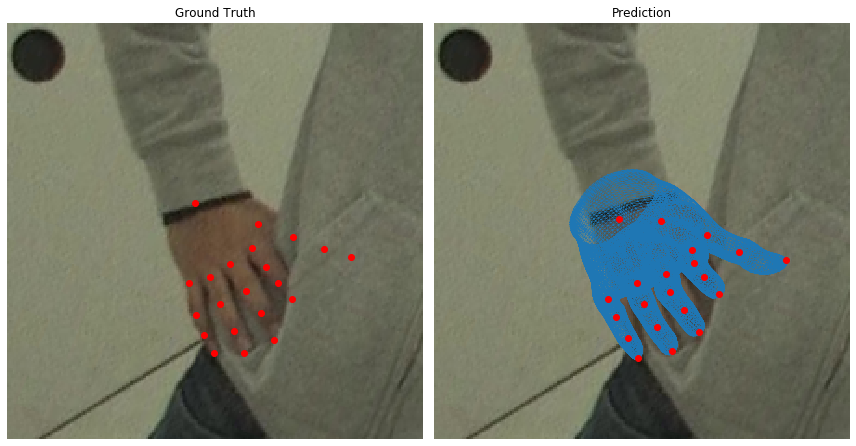

In [9]:
for index in range(batch_size // 8):
    R, t, s = cv2.Rodrigues(rot_out[index])[0], trans_out[index], scale_out[index]
    align_mesh = s * np.dot(R, reconstruction[index].T).T + t

    visualize_keypoints(gt_X_viz[index], gt_lms[index], out_lms[index], align_mesh, trilist)

## Save the meshes

In [10]:
PREDICTIONS_PATH = join(OUTPUT_PATH, 'mesh-predictions')

for index in range(batch_size // 8):

    export_obj(reconstruction[index], trilist, 
                     join(PREDICTIONS_PATH, '{}_pred.obj'.format(index)))

    export_obj(rec_label[index], trilist, 
                     join(PREDICTIONS_PATH, '{}_gt.obj'.format(index)))